# Imports and Configuration Files

In [136]:
import pandas as pd
from scipy import stats
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import json
from copy import deepcopy
import pyfixest as pf
import psycopg
import statsmodels.api as sm
import seaborn as sns

LOOKUPS = json.load(open("./json/lookups.json", "r"))
DECODE = json.load(open("./json/decode.json", "r"))
CHARGES = json.load((open("./json/charges_more_attrs.json", "r")))
CHARGE_CATS = set(CHARGES[chg]["category"] for chg in CHARGES)


# Configuration Instructions
* Add the court code of interest in the `COURT` variable. The court codes are available in [the lookups file](./json/lookups.json)
* If you're bringing your own data from EOIR's CASE Database, you may need to change the names of the tables

In [137]:
# --- CONFIGURATION ---
POSTFIX = '03_25'
COURT = 'HSG'
START_DATE = '2024-09-11'

# --- TABLE NAMES (auto-generated based on POSTFIX) ---
schedule_table = f"foia_schedule_{POSTFIX}"
case_table = f"foia_case_{POSTFIX}"
proceeding_table = f"foia_proceeding_{POSTFIX}"
rider_table = f"foia_rider_{POSTFIX}"
charge_table = f"foia_charges_{POSTFIX}"


# Database connection parameters - you'll need to fill these in
db_params = {
    'dbname': 'bklg_test',  # Based on your schema info
    'user': 'bklg',             # Fill in your username
    'password': 'devpassword',         # Fill in your password
    'host': 'localhost',    # Change if needed
    'port': '5432'          # Change if needed
}

# Function to connect to the database
def connect_to_db(params):
    """Establish connection to the PostgreSQL database"""
    try:
        conn = psycopg.connect(**params)
        print("Database connection established successfully")
        return conn
    except Exception as e:
        print(f"Error connecting to the database: {e}")
        return None


conn = connect_to_db(db_params)
conn

Database connection established successfully


<psycopg.Connection [IDLE] (host=localhost user=bklg database=bklg_test) at 0x7f4a53512c20>

# Asylum Case Retrieval

In [138]:
# Query to get asylum applications for HSG after Feb 1, 2022
query = f"""
WITH asylum_applications AS (
    SELECT 
        fa.idncase, fa.idnproceeding, fa.appl_code, fa.appl_dec, fa.appl_recd_date,
        ROW_NUMBER() OVER (PARTITION BY fa.idnproceeding ORDER BY fa.appl_recd_date DESC) as rn
    FROM foia_application_{POSTFIX} fa
    WHERE fa.appl_code = 'ASYL' AND fa.appl_dec IN ('G', 'D')
)
SELECT 
    aa.idncase, aa.idnproceeding, aa.appl_dec, aa.appl_recd_date,
    p.ij_code, c.latest_hearing, c.latest_time, p.hearing_date, p.hearing_time, p.comp_date, p.base_city_code, p.custody, p.crim_ind, p.casetype, p.osc_date,
    c.nat, c.lang, c.e_28_date, c.casepriority_code, c.date_of_entry, c.c_birthdate, c.gender, c.lpr
FROM asylum_applications aa
JOIN {proceeding_table} p ON aa.idnproceeding = p.idnproceeding
JOIN {case_table} c ON aa.idncase = c.idncase
WHERE aa.rn = 1
    AND p.base_city_code = 'HSG'
    AND p.comp_date > '2022-02-01'
"""

asylum_df = pd.read_sql_query(query, conn)
print(f"Retrieved {len(asylum_df)} Houston asylum applications after Feb 1, 2022")
asylum_df.head()

/tmp/ipykernel_900620/3033480509.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  asylum_df = pd.read_sql_query(query, conn)


Retrieved 2866 Houston asylum applications after Feb 1, 2022


,idncase,idnproceeding,appl_dec,appl_recd_date,ij_code,latest_hearing,latest_time,hearing_date,hearing_time,comp_date,...,casetype,osc_date,nat,lang,e_28_date,casepriority_code,date_of_entry,c_birthdate,gender,lpr
0,5784579,4288090,D,2018-01-05 00:00:00.000,NES,2023-04-11,08:30:00,2007-11-08,08:30:00,2023-06-08,...,RMV,2007-07-11,PK,ENG,2017-10-24,None,NaT,None,None,None
1,5870541,4782015,D,2009-04-21 00:00:00.000,NES,2022-01-26,08:00:00,2009-04-21,08:00:00,2022-02-04,...,RMV,2006-11-01,IN,GUJ,2017-06-14,None,2006-11-01,None,None,None
2,6188414,4795705,D,2018-05-04 00:00:00.000,NES,2022-02-18,08:00:00,2009-05-11,08:00:00,2022-02-22,...,RMV,2009-03-10,PE,SP,2013-05-14,None,2003-03-03,None,None,None
3,3006125,4821463,D,2009-04-20 13:58:01.127,NES,2022-02-17,10:00:00,2009-06-03,08:30:00,2022-02-22,...,RMV,1999-02-04,GT,SP,2022-02-03,None,1993-08-21,None,None,None
4,6264724,4880640,D,2009-06-23 00:00:00.000,NES,2022-02-23,08:00:00,2009-07-23,08:30:00,2022-02-28,...,RMV,2009-06-22,ES,SP,2018-03-08,None,1989-02-01,None,None,None


In [155]:
asylum_df['comp_date'].min()

Timestamp('2022-02-04 00:00:00')

In [139]:
# Query to get all schedule records for each proceeding in our asylum dataset
query_schedules = f"""
SELECT 
    s.*
FROM 
    {schedule_table} s
JOIN (
    SELECT DISTINCT idnproceeding
    FROM asylum_df
) p ON s.idnproceeding = p.idnproceeding
ORDER BY 
    s.idnproceeding, 
    CASE 
        WHEN s.input_date IS NOT NULL THEN s.input_date
        ELSE s.adj_date
    END
"""

# Create a temporary table for the subset of idnproceedings
with conn.cursor() as cur:
    # Create a temporary table with our proceeding IDs
    cur.execute(f"DROP TABLE IF EXISTS temp_asylum_proceedings ;")
    cur.execute(f"CREATE TEMPORARY TABLE temp_asylum_proceedings AS SELECT DISTINCT idnproceeding FROM ({query}) q")
    
    # Query all schedule records for these proceedings
    schedules_query = f"""
    SELECT s.*
    FROM {schedule_table} s
    JOIN temp_asylum_proceedings t ON s.idnproceeding = t.idnproceeding
    ORDER BY s.idnproceeding, s.input_date
    """
    
    schedules_df = pd.read_sql_query(schedules_query, conn)

print(f"Retrieved {len(schedules_df)} schedule records for {asylum_df['idnproceeding'].nunique()} proceedings")
schedules_df.head()

/tmp/ipykernel_900620/1231864239.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  schedules_df = pd.read_sql_query(schedules_query, conn)


Retrieved 14758 schedule records for 2866 proceedings


,idnschedule,idnproceeding,idncase,osc_date,generation,sub_generation,rec_type,lang,hearing_loc_code,base_city_code,...,adj_time_stop,adj_rsn,adj_med,adj_msg,adj_elap_days,lngsessnid,schedule_type,notice_code,blnclockoverride,eoirattorneyid
0,19298602,4288090,5784579,2007-07-11,98,NaN,X,ENG,HOU,HOU,...,09:00:00,25,P,None,NaN,2458900.0,MM,V3,None,67BA7493-3683-E211-AC6D-F4CE46838609
1,19415880,4288090,5784579,2007-07-11,98,NaN,X,ENG,HOU,HOU,...,09:00:00,02,P,None,NaN,2504821.0,MR,None,None,67BA7493-3683-E211-AC6D-F4CE46838609
2,19498273,4288090,5784579,2007-07-11,98,NaN,X,ENG,HOU,HOU,...,09:30:00,7A,P,None,NaN,2708108.0,MR,None,None,67BA7493-3683-E211-AC6D-F4CE46838609
3,19761854,4288090,5784579,2007-07-11,98,NaN,X,ENG,HOU,HOU,...,09:30:00,7A,P,None,NaN,2988514.0,MR,V3,None,67BA7493-3683-E211-AC6D-F4CE46838609
4,20181850,4288090,5784579,2007-07-11,98,NaN,X,ENG,HOU,HOU,...,09:30:00,7A,P,None,NaN,3264884.0,MR,None,None,67BA7493-3683-E211-AC6D-F4CE46838609


# Get First Scheduling Records Where Judge Was Assigned for Each Decided Proceeding
Look for scheduling records that have decision-related adjournment codes matching the comp_date and judge
If no exact match, look for decision-related records within a week of the comp_date
If still no match, look for any records on the comp_date with the same judge

In [140]:
DECISION_ADJ_CODES = ['8A', '8B', 'RR', 'RD', 'DD']

def process_asylum_cases(asylum_df, schedules_df):
    """
    Process asylum cases to match them with the correct scheduling records
    that indicate when and by which judge the decision was made
    """
    # Create a copy to avoid modifying the original
    asylum_with_schedules = asylum_df.copy()
    
    # Create columns to track if we found a matching decision schedule
    asylum_with_schedules['has_decision_schedule'] = False
    asylum_with_schedules['decision_schedule_id'] = None
    asylum_with_schedules['decision_adj_code'] = None
    asylum_with_schedules['decision_adj_decode'] = None
    
    # Create a lookup dictionary for adjournment code descriptions
    adj_code_lookup = {
        '8A': "IJ Completion prior to hearing",
        '8B': "IJ COMPLETION AT HEARING",
        'RR': "RESERVED DECISION",
        'RD': "RESERVED SUSPENSION DECISION",
        'DD': "DECISION DELAYED"
    }
    
    # Process each asylum case
    for i, case in asylum_with_schedules.iterrows():
        # Get all scheduling records for this proceeding
        case_schedules = schedules_df[
            (schedules_df['idnproceeding'] == case['idnproceeding']) & 
            (schedules_df['cal_type'] == 'I')  # Individual hearings only
        ].sort_values('adj_date')
        
        if len(case_schedules) == 0:
            continue
        
        # First priority: Look for matching decision codes with ij_code and comp_date
        decision_schedules = case_schedules[
            (case_schedules['adj_rsn'].isin(DECISION_ADJ_CODES)) &
            (case_schedules['ij_code'] == case['ij_code']) &
            (case_schedules['adj_date'] == case['comp_date'])
        ]
        
        if len(decision_schedules) > 0:
            # Found a perfect match
            decision_schedule = decision_schedules.iloc[0]
            asylum_with_schedules.at[i, 'has_decision_schedule'] = True
            asylum_with_schedules.at[i, 'decision_schedule_id'] = decision_schedule['idnschedule']
            asylum_with_schedules.at[i, 'decision_adj_code'] = decision_schedule['adj_rsn']
            asylum_with_schedules.at[i, 'decision_adj_decode'] = adj_code_lookup.get(
                decision_schedule['adj_rsn'], decision_schedule['adj_rsn']
            )
            continue
        
        # Second priority: Look for matching decision codes with ij_code around comp_date
        decision_schedules = case_schedules[
            (case_schedules['adj_rsn'].isin(DECISION_ADJ_CODES)) &
            (case_schedules['ij_code'] == case['ij_code']) &
            (case_schedules['adj_date'] >= case['comp_date'] - timedelta(days=7)) &
            (case_schedules['adj_date'] <= case['comp_date'] + timedelta(days=7))
        ]
        
        if len(decision_schedules) > 0:
            # Found a close match
            decision_schedule = decision_schedules.iloc[0]
            asylum_with_schedules.at[i, 'has_decision_schedule'] = True
            asylum_with_schedules.at[i, 'decision_schedule_id'] = decision_schedule['idnschedule']
            asylum_with_schedules.at[i, 'decision_adj_code'] = decision_schedule['adj_rsn']
            asylum_with_schedules.at[i, 'decision_adj_decode'] = adj_code_lookup.get(
                decision_schedule['adj_rsn'], decision_schedule['adj_rsn']
            )
            continue
        
        # Third priority: Try matching with the comp_date and ij_code
        matching_schedules = case_schedules[
            (case_schedules['ij_code'] == case['ij_code']) &
            (case_schedules['adj_date'] == case['comp_date'])
        ]
        
        if len(matching_schedules) > 0:
            # Found a date match
            matching_schedule = matching_schedules.iloc[0]
            asylum_with_schedules.at[i, 'has_decision_schedule'] = True
            asylum_with_schedules.at[i, 'decision_schedule_id'] = matching_schedule['idnschedule']
            asylum_with_schedules.at[i, 'decision_adj_code'] = matching_schedule['adj_rsn']
            asylum_with_schedules.at[i, 'decision_adj_decode'] = adj_code_lookup.get(
                matching_schedule['adj_rsn'], matching_schedule['adj_rsn']
            )
            
    # Filter to cases with identified decision schedules
    asylum_with_decision_schedules = asylum_with_schedules[
        asylum_with_schedules['has_decision_schedule']
    ]
    
    return asylum_with_decision_schedules

filt_asy_df = process_asylum_cases(asylum_df, schedules_df)
print(f"Length of filtered dataset: {len(filt_asy_df)}")
print(f"Records filtered: {len(asylum_df) - len(filt_asy_df)}")

Length of filtered dataset: 2161
Records filtered: 705


In [141]:
def extract_initial_scheduling_records(filt_asy_df, schedules_df):
    """
    Extract only the initial scheduling records for each case in the filtered asylum dataset.
    
    Returns:
    - DataFrame with one row per asylum case containing the initial scheduling record
    """
    # Create an empty list to store our initial scheduling records
    initial_records = []
    
    # Counter for diagnostics
    missing_records = 0
    reassigned_cases = 0
    
    # Process each filtered asylum case
    for _, case in filt_asy_df.iterrows():
        proc_id = case['idnproceeding']
        decision_judge = case['ij_code']
        
        # Get all scheduling records for this proceeding ordered by date
        case_schedules = schedules_df[
            (schedules_df['idnproceeding'] == proc_id) &
            (schedules_df['cal_type'] == 'I')  # Individual hearings only
        ].sort_values(['input_date', 'input_time'])
        
        if len(case_schedules) == 0:
            missing_records += 1
            if missing_records <= 5:  # Limit logging
                print(f"Warning: No scheduling records found for proceeding {proc_id}")
            continue
            
        # Get just the judge assignments for this case
        judge_assignments = case_schedules[['idnschedule', 'input_date', 'input_time', 'ij_code']].copy()
        judge_assignments = judge_assignments[judge_assignments['ij_code'].notna()]
        
        if len(judge_assignments) == 0:
            missing_records += 1
            continue
        
        # Find the first time the decision judge was assigned
        decision_judge_assignments = judge_assignments[judge_assignments['ij_code'] == decision_judge]
        
        if len(decision_judge_assignments) == 0:
            missing_records += 1
            if missing_records <= 5:  # Limit logging
                print(f"Warning: No records found with judge {decision_judge} for proceeding {proc_id}")
            continue
        
        # First assignment to this judge
        first_assignment_id = decision_judge_assignments.iloc[0]['idnschedule']
        
        # Check if this was a reassignment
        if judge_assignments.iloc[0]['ij_code'] != decision_judge:
            reassigned_cases += 1
        
        # Get the full scheduling record for this assignment
        initial_schedule = schedules_df[schedules_df['idnschedule'] == first_assignment_id].iloc[0].to_dict()
        
        # Add the asylum case information to this record
        for field in ['idncase', 'idnproceeding', 'appl_dec', 'comp_date']:
            initial_schedule[field] = case[field]
        
        # Add a flag indicating if this was a reassignment
        initial_schedule['is_reassigned'] = (judge_assignments.iloc[0]['ij_code'] != decision_judge)
        
        # Add to our collection
        initial_records.append(initial_schedule)
    
    # Convert to DataFrame
    initial_schedules_df = pd.DataFrame(initial_records)
    
    # Print summary statistics
    print(f"\nSummary:")
    print(f"Total cases: {len(filt_asy_df)}")
    print(f"Cases with matching initial schedule: {len(initial_records)}")
    print(f"Cases with no matching records: {missing_records}")
    print(f"Reassigned cases: {reassigned_cases} ({reassigned_cases/len(initial_records)*100:.1f}% of matched cases)")
    
    return initial_schedules_df
    
# Extract initial scheduling records
initial_schedules_df = extract_initial_scheduling_records(filt_asy_df, schedules_df)

# Check the resulting dataframe
print(f"\nInitial schedules dataframe shape: {initial_schedules_df.shape}")
print(f"Sample of initial schedules:")
initial_cols = ['idncase', 'idnproceeding', 'idnschedule', 'ij_code', 'input_date', 'is_reassigned']
print(initial_schedules_df[initial_cols].head(20))


Summary:
Total cases: 2161
Cases with matching initial schedule: 2161
Cases with no matching records: 0
Reassigned cases: 633 (29.3% of matched cases)

Initial schedules dataframe shape: (2161, 33)
Sample of initial schedules:
    idncase  idnproceeding  idnschedule ij_code input_date  is_reassigned
0   6188414        4795705     40233906     NES 2021-12-28           True
1   3006125        4821463     40329948     NES 2022-01-10           True
2   6264724        4880640     40334194     NES 2022-01-10           True
3   6215700        4884001     40354901     NES 2022-01-12           True
4   6268506        4921623     40333845     NES 2022-01-10           True
5   6235411        4934753     40355001     NES 2022-01-12           True
6   5536856        4957879     37096227     DAJ 2018-05-01           True
7   6515425        5200660     34535595     KBR 2018-05-02           True
8   6570452        5278866     45198150     NES 2023-05-24           True
9   6529528        5450459     3

<Axes: >

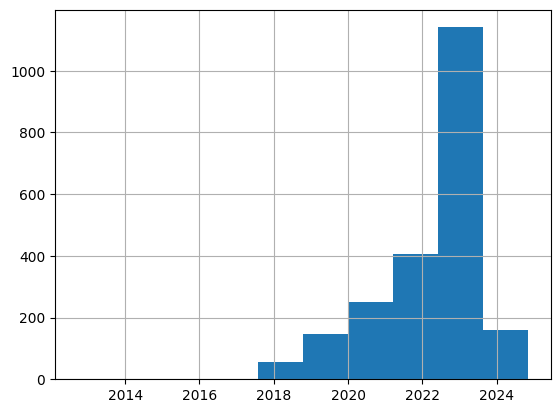

In [142]:
initial_schedules_df['input_date'].hist()


In [143]:
initial_schedules_df['input_date'].min()

Timestamp('2012-09-19 00:00:00')

In [144]:
hsg_08 = pd.read_csv('hsg_schedules_2008_2025.csv')

In [145]:
init_sched_set = set(initial_schedules_df['idnschedule'].unique())
hsg_08_set = set(hsg_08['idnschedule'].unique())
len(init_sched_set.difference(hsg_08_set))

810

In [146]:
should_be = set(initial_schedules_df[initial_schedules_df['base_city_code'] == 'HSG']['idnschedule'].unique())

In [153]:
z = filt_asy_df['ij_code'].value_counts()
z[z > 30]

ij_code
CMS    340
AAJ    272
DAJ    257
GYH    239
KBR    235
CDK    132
JJC    123
JNM    117
KYT    106
CMR    100
DMP     94
MGC     54
AWS     44
Name: count, dtype: int64

In [162]:
def build_hsg_individual_hearings_df(conn, postfix='03_25'):
    """
    Build a complete dataframe of individual hearing scheduling records at HSG court
    with proper handling of NULL time values.
    """
    print("Querying database for individual hearings at HSG court...")
    
    # Define the SQL query with COALESCE to handle NULL time values
    query = f"""
    SELECT 
        idnschedule, 
        idnproceeding, 
        idncase, 
        ij_code,
        base_city_code,
        cal_type,
        input_date,
        COALESCE(input_time, '00:00:00'::time) as input_time,
        adj_date,
        COALESCE(adj_time_start, '00:00:00'::time) as adj_time_start,
        update_date,
        COALESCE(update_time, '00:00:00'::time) as update_time,
        adj_rsn,
        (input_date + COALESCE(input_time, '00:00:00'::time)) AS scheduled_datetime,
        adj_date AS hearing_date,
        COALESCE(adj_time_start, '00:00:00'::time) AS hearing_time,
        (adj_date + COALESCE(adj_time_start, '00:00:00'::time)) AS hearing_datetime,
        (update_date + COALESCE(update_time, '00:00:00'::time)) AS update_datetime
    FROM foia_schedule_{postfix}
    WHERE cal_type = 'I' AND base_city_code = 'HSG'
    ORDER BY input_date, input_time
    """
    
    # Execute the query and load into a dataframe
    hsg_ind_hearings = pd.read_sql_query(query, conn)
    
    # Convert datetime columns to proper pandas datetime objects
    datetime_cols = ['scheduled_datetime', 'hearing_datetime', 'update_datetime']
    for col in datetime_cols:
        if col in hsg_ind_hearings.columns:
            hsg_ind_hearings[col] = pd.to_datetime(hsg_ind_hearings[col], errors='coerce')
    
    # Convert date columns
    date_cols = ['input_date', 'adj_date', 'update_date', 'hearing_date']
    for col in date_cols:
        if col in hsg_ind_hearings.columns:
            hsg_ind_hearings[col] = pd.to_datetime(hsg_ind_hearings[col], errors='coerce')
    
    print(f"Retrieved {len(hsg_ind_hearings)} individual hearing records at HSG court")
    
    # Check for missing values in critical datetime fields
    for col in datetime_cols:
        null_count = hsg_ind_hearings[col].isna().sum()
        if null_count > 0:
            print(f"Warning: {null_count} records have null {col} values")
    
    return hsg_ind_hearings

def verify_reference_data(hsg_hearings_df, initial_schedules_df):
    """
    Verify the HSG hearings dataframe has expected properties.
    """
    print("\nVerification of HSG Individual Hearings DataFrame:")
    print(f"Total records: {len(hsg_hearings_df)}")
    print(f"Unique cases: {hsg_hearings_df['idncase'].nunique()}")
    print(f"Unique judges: {hsg_hearings_df['ij_code'].nunique()}")
    print(f"Date range: {hsg_hearings_df['input_date'].min()} to {hsg_hearings_df['input_date'].max()}")
    
    # Check if all our initial_schedules_df records are included
    initial_ids = set(initial_schedules_df['idnschedule'].unique())
    hsg_ids = set(hsg_hearings_df['idnschedule'].unique())
    missing_ids = initial_ids - hsg_ids
    
    if missing_ids:
        print(f"WARNING: {len(missing_ids)} records from initial_schedules_df are not in the reference dataset!")
        print(f"First 5 missing IDs: {list(missing_ids)[:5]}")
        
        # Sample some missing records to understand why they're missing
        sample_missing = initial_schedules_df[initial_schedules_df['idnschedule'].isin(list(missing_ids)[:5])]
        print("\nSample of missing records:")
        for idx, row in sample_missing.iterrows():
            base_city = row.get('base_city_code', 'N/A')
            cal_type = row.get('cal_type', 'N/A')
            print(f"ID: {row['idnschedule']}, Base City: {base_city}, Cal Type: {cal_type}")
    else:
        print("All records from initial_schedules_df are present in the reference dataset.")
    
    # Display a few example records to visually verify
    print("\nSample records from reference dataset:")
    print(hsg_hearings_df[['idnschedule', 'ij_code', 'scheduled_datetime', 'hearing_datetime']].head())
    
    return
# Connect to the database
conn = connect_to_db(db_params)

# Build the reference dataframe
hsg_hearings_df = build_hsg_individual_hearings_df(conn)

# Verify it includes our initial records
verify_reference_data(hsg_hearings_df, initial_schedules_df)

Database connection established successfully
Querying database for individual hearings at HSG court...


/tmp/ipykernel_900620/4004133887.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  hsg_ind_hearings = pd.read_sql_query(query, conn)


Retrieved 71873 individual hearing records at HSG court

Verification of HSG Individual Hearings DataFrame:
Total records: 71873
Unique cases: 38349
Unique judges: 60
Date range: 2007-03-09 23:18:17.777000 to 2025-02-28 00:00:00
First 5 missing IDs: [np.int64(25299834), np.int64(24788517)]

Sample of missing records:
ID: 24788517, Base City: HOU, Cal Type: I
ID: 25299834, Base City: HOU, Cal Type: I

Sample records from reference dataset:
   idnschedule ij_code      scheduled_datetime    hearing_datetime
0     12065775     JLB 2007-03-10 22:36:17.777 1997-01-23 13:00:00
1     13563479     JLB 2007-04-07 22:44:38.713 1996-08-28 09:00:00
2     13607621     JLB 2007-04-07 22:58:03.980 1997-07-17 13:00:00
3     13618537     JLB 2007-04-07 23:10:06.840 2000-05-11 09:00:00
4     13618712     JLB 2007-04-07 23:10:06.840 2000-08-10 13:00:00


In [163]:
hsg_hearings_set = set(hsg_hearings_df['idnschedule'].unique())
len(init_sched_set.difference(hsg_hearings_set))

2

In [165]:
def calculate_caseload(initial_df, reference_df):
    """
    Calculate the caseload for each judge at the time of each scheduling record
    with robust datetime handling.
    """
    print("Calculating caseload...")
    
    # Create a copy of the initial dataframe to modify
    result_df = initial_df.copy()
    result_df['caseload'] = 0  # Initialize caseload column
    
    # Create a dictionary to store caseloads for reuse
    caseload_cache = {}
    
    # For reporting
    cache_hits = 0
    datetime_errors = 0
    
    # Process each record
    for idx, row in result_df.iterrows():
        judge = row['ij_code']
        
        # Get scheduling datetime with robust error handling
        try:
            if 'scheduled_datetime' in row and pd.notna(row['scheduled_datetime']):
                sched_dt = row['scheduled_datetime']
            elif 'input_date' in row and 'input_time' in row:
                # Handle possible None values in input_time
                time_str = '00:00:00' if row['input_time'] is None else row['input_time']
                date_str = row['input_date'].strftime('%Y-%m-%d') if not isinstance(row['input_date'], str) else row['input_date']
                sched_dt = pd.to_datetime(f"{date_str} {time_str}")
            else:
                print(f"Warning: Cannot determine scheduling datetime for record {idx}")
                datetime_errors += 1
                continue
        except Exception as e:
            print(f"Error creating datetime for record {idx}: {e}")
            print(f"  input_date: {row.get('input_date', 'N/A')}")
            print(f"  input_time: {row.get('input_time', 'N/A')}")
            datetime_errors += 1
            continue
        
        # Create a cache key
        cache_key = (judge, str(sched_dt))
        
        # Check if we already calculated this caseload
        if cache_key in caseload_cache:
            result_df.at[idx, 'caseload'] = caseload_cache[cache_key]
            cache_hits += 1
            continue
        
        # Filter for active cases
        try:
            active_cases = reference_df[
                # Same judge
                (reference_df['ij_code'] == judge) &
                # Criterion 1: Scheduled before the current scheduling event
                (reference_df['scheduled_datetime'] <= sched_dt) &
                # Criterion 2: Hearing date is after the current scheduling event
                (reference_df['hearing_datetime'] > sched_dt) &
                # Criterion 3: Not adjourned before the current scheduling event
                (
                    reference_df['adj_rsn'].isna() | 
                    (reference_df['update_datetime'] > sched_dt)
                )
            ]
            
            # Count unique cases
            caseload = active_cases['idncase'].nunique()
            
            # Store in cache
            caseload_cache[cache_key] = caseload
            
            # Update the result dataframe
            result_df.at[idx, 'caseload'] = caseload
            
        except Exception as e:
            print(f"Error calculating caseload for record {idx}: {e}")
            continue
    
    # Print summary statistics
    print(f"Caseload calculation complete for {len(result_df)} records")
    print(f"  Cache hits: {cache_hits}")
    print(f"  Datetime errors: {datetime_errors}")
    print(f"  Mean caseload: {result_df['caseload'].mean():.2f}")
    print(f"  Min caseload: {result_df['caseload'].min()}")
    print(f"  Max caseload: {result_df['caseload'].max()}")
    print(f"  Zero caseloads: {(result_df['caseload'] == 0).sum()} records")
    
    return result_df

# Apply the caseload calculation
initial_df_with_caseload = calculate_caseload(initial_schedules_df, hsg_hearings_df)

Calculating caseload...
Caseload calculation complete for 2161 records
  Cache hits: 688
  Datetime errors: 0
  Mean caseload: 743.79
  Min caseload: 0
  Max caseload: 2406
  Zero caseloads: 2 records


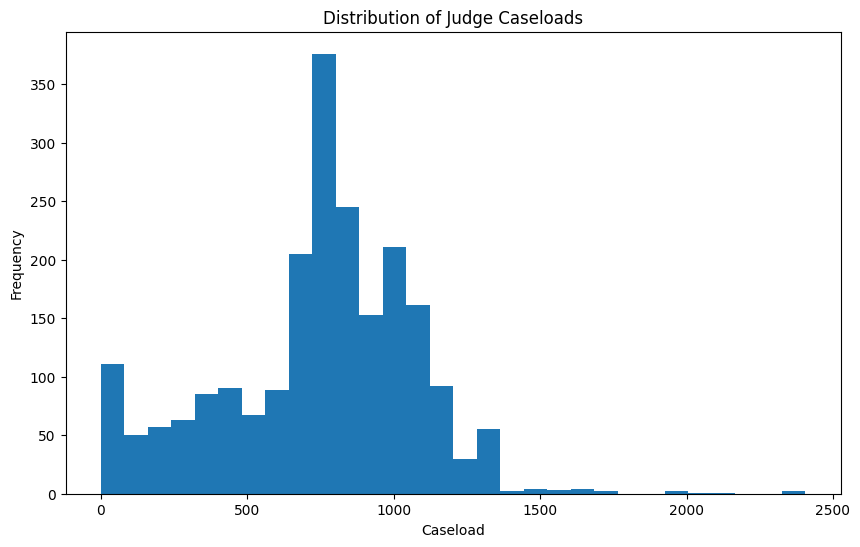


Caseload by Judge (top 10):
               mean  min   max  count
ij_code                              
CMR      925.760000    0  2406    100
GYH      925.397490   16  1563    239
KYT      866.811321  459  1168    106
KBR      844.578723   35  1301    235
DAJ      817.031128    2  1231    257
CMS      795.914706   16  1271    340
AAJ      765.147059   83  1093    272
MGC      719.796296   38  1140     54
DMP      570.351064   15  1306     94
CDK      553.121212   54   810    132


In [166]:
# Display distribution of caseload
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(initial_df_with_caseload['caseload'], bins=30)
plt.title('Distribution of Judge Caseloads')
plt.xlabel('Caseload')
plt.ylabel('Frequency')
plt.show()

# Display caseload by judge
judge_caseloads = initial_df_with_caseload.groupby('ij_code')['caseload'].agg(['mean', 'min', 'max', 'count'])
judge_caseloads = judge_caseloads.sort_values('mean', ascending=False)
print("\nCaseload by Judge (top 10):")
print(judge_caseloads.head(10))

In [167]:
initial_df_with_caseload

,idnschedule,idnproceeding,idncase,osc_date,generation,sub_generation,rec_type,lang,hearing_loc_code,base_city_code,...,adj_elap_days,lngsessnid,schedule_type,notice_code,blnclockoverride,eoirattorneyid,appl_dec,comp_date,is_reassigned,caseload
0,40233906,4795705,6188414,2009-03-10,98,NaN,X,ENG,HSG,HSG,...,398.0,15093018.0,II,Y2,None,0FBC7493-3683-E211-AC6D-F4CE46838609,D,2022-02-22,True,137
1,40329948,4821463,3006125,1999-02-04,97,NaN,X,SP,HSG,HSG,...,NaN,15093031.0,II,V3,None,C6F8E064-1FE2-E411-A083-F4CE46822D51,D,2022-02-22,True,144
2,40334194,4880640,6264724,2009-06-22,99,NaN,X,SP,HSG,HSG,...,NaN,15139884.0,II,V3,None,A6BE9B7D-6CF0-46AB-81AD-308D90F74DDE,D,2022-02-28,True,156
3,40354901,4884001,6215700,2009-04-14,98,NaN,X,SP,HSG,HSG,...,NaN,15139899.0,II,V3,None,E7659A18-6367-E311-84E6-F4CE46838609,D,2022-02-28,True,156
4,40333845,4921623,6268506,2009-06-18,98,NaN,X,SP,HSG,HSG,...,351.0,15139866.0,II,V3,None,40BA7493-3683-E211-AC6D-F4CE46838609,D,2022-02-18,True,154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2156,50920221,14641116,9885110,2021-02-24,98,NaN,X,SP,HSG,HSG,...,2.0,17363428.0,II,NH,None,C441DB8C-8CC7-4273-8479-9648307A0CB8,D,2024-08-21,True,383
2157,50920222,14641118,9885134,2021-02-24,98,NaN,X,SP,HSG,HSG,...,2.0,17363428.0,II,NH,None,C441DB8C-8CC7-4273-8479-9648307A0CB8,D,2024-08-21,True,383
2158,50920223,14641122,9885149,2021-02-24,98,NaN,X,SP,HSG,HSG,...,2.0,17363428.0,II,NH,None,C441DB8C-8CC7-4273-8479-9648307A0CB8,D,2024-08-21,True,383
2159,50647687,14676830,13842624,2024-03-28,98,NaN,X,SP,HSG,HSG,...,157.0,17566531.0,II,NH,None,250546F2-E0D1-4D7B-B7E9-DCF33392670D,D,2025-01-17,False,1231


Calculating time to next scheduling...
Time to next calculation complete for 2161 records
  Cache hits: 688
  Records with no next scheduling: 0
  Mean time to next (days): 2.31
  Min time to next (days): 0.00
  Max time to next (days): 1888.92


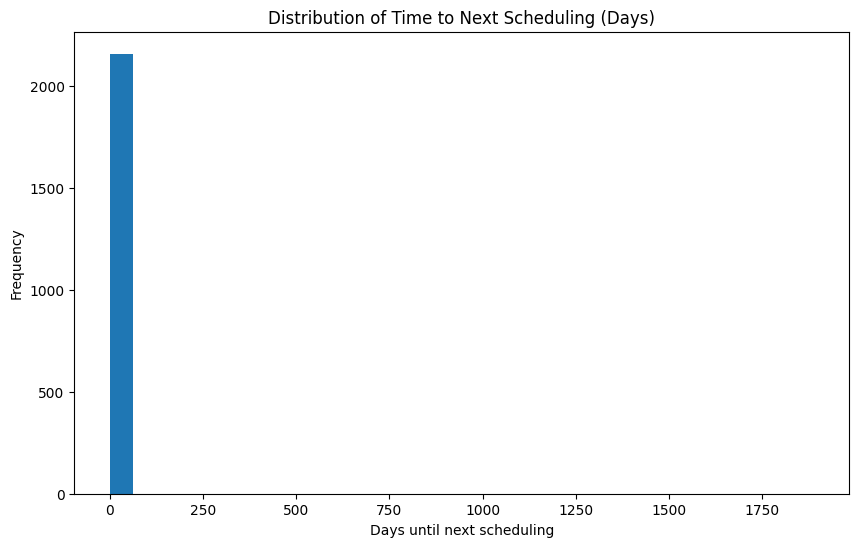

In [168]:
def calculate_time_to_next(initial_df, reference_df):
    """
    Calculate the time until the next scheduling for each judge
    
    Parameters:
    - initial_df: DataFrame with our asylum case scheduling records
    - reference_df: DataFrame with all HSG individual hearing records
    
    Returns:
    - Updated DataFrame with 'time_to_next' column added
    """
    print("Calculating time to next scheduling...")
    
    # Create a copy of the initial dataframe to modify
    result_df = initial_df.copy()
    result_df['time_to_next'] = None  # Initialize time_to_next column
    
    # Create a dictionary to store next scheduling times for cache optimization
    next_time_cache = {}
    
    # For reporting
    cache_hits = 0
    no_next_found = 0
    
    # Process each record
    for idx, row in result_df.iterrows():
        judge = row['ij_code']
        
        # Get scheduling datetime with robust error handling
        try:
            if 'scheduled_datetime' in row and pd.notna(row['scheduled_datetime']):
                sched_dt = row['scheduled_datetime']
            elif 'input_date' in row and 'input_time' in row:
                # Handle possible None values in input_time
                time_str = '00:00:00' if row['input_time'] is None else row['input_time']
                date_str = row['input_date'].strftime('%Y-%m-%d') if not isinstance(row['input_date'], str) else row['input_date']
                sched_dt = pd.to_datetime(f"{date_str} {time_str}")
            else:
                print(f"Warning: Cannot determine scheduling datetime for record {idx}")
                continue
        except Exception as e:
            print(f"Error creating datetime for record {idx}: {e}")
            continue
        
        # Create a cache key
        cache_key = (judge, str(sched_dt))
        
        # Check if we already calculated this "time to next"
        if cache_key in next_time_cache:
            result_df.at[idx, 'time_to_next'] = next_time_cache[cache_key]
            cache_hits += 1
            continue
        
        # Find the next scheduling for this judge
        next_scheduling = reference_df[
            (reference_df['ij_code'] == judge) &
            (reference_df['scheduled_datetime'] > sched_dt)
        ].sort_values('scheduled_datetime')
        
        if len(next_scheduling) > 0:
            # Calculate the time difference in days
            next_sched_dt = next_scheduling.iloc[0]['scheduled_datetime']
            time_to_next = (next_sched_dt - sched_dt).total_seconds() / (24 * 3600)  # Convert to days
            
            # Store in cache and update dataframe
            next_time_cache[cache_key] = time_to_next
            result_df.at[idx, 'time_to_next'] = time_to_next
        else:
            # No next scheduling found for this judge
            no_next_found += 1
            result_df.at[idx, 'time_to_next'] = None
    
    # Print summary statistics
    print(f"Time to next calculation complete for {len(result_df)} records")
    print(f"  Cache hits: {cache_hits}")
    print(f"  Records with no next scheduling: {no_next_found}")
    
    # Add some summary statistics if there are valid time_to_next values
    valid_times = result_df['time_to_next'].dropna()
    if len(valid_times) > 0:
        print(f"  Mean time to next (days): {valid_times.mean():.2f}")
        print(f"  Min time to next (days): {valid_times.min():.2f}")
        print(f"  Max time to next (days): {valid_times.max():.2f}")
    
    return result_df

# Apply the time to next calculation
df_with_features = calculate_time_to_next(initial_df_with_caseload, hsg_hearings_df)

# Visualize the distribution of time to next
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_with_features['time_to_next'].dropna(), bins=30)
plt.title('Distribution of Time to Next Scheduling (Days)')
plt.xlabel('Days until next scheduling')
plt.ylabel('Frequency')
plt.show()

In [169]:
def add_no_cases_feature(df):
    """
    Add a binary feature indicating whether a judge had zero cases at the time of scheduling
    
    Parameters:
    - df: DataFrame with 'caseload' column already calculated
    
    Returns:
    - Updated DataFrame with 'no_cases' column added
    """
    print("Adding 'no_cases' indicator feature...")
    
    # Create a copy of the dataframe to modify
    result_df = df.copy()
    
    # Set to 1 if caseload is 0, otherwise 0
    result_df['no_cases'] = (result_df['caseload'] == 0).astype(int)
    
    # Print summary statistics
    count_zero = result_df['no_cases'].sum()
    print(f"No cases indicator complete")
    print(f"  Records with no cases: {count_zero} ({count_zero/len(result_df)*100:.2f}%)")
    
    return result_df

def add_previously_assigned_feature(df, reference_df):
    """
    Add a feature indicating if the judge matches the most recently scheduled judge at HSG court
    
    Parameters:
    - df: DataFrame with our asylum case scheduling records
    - reference_df: DataFrame with all HSG individual hearing records
    
    Returns:
    - Updated DataFrame with 'previously_assigned' column added
    """
    print("Calculating 'previously_assigned' feature...")
    
    # Create a copy of the dataframe to modify
    result_df = df.copy()
    result_df['previously_assigned'] = 0  # Initialize feature column
    
    # Create a dictionary to cache results
    prev_judge_cache = {}
    
    # Get all HSG individual hearings and sort chronologically
    hsg_hearings = reference_df[
        (reference_df['base_city_code'] == 'HSG') & 
        (reference_df['cal_type'] == 'I')
    ].sort_values(['scheduled_datetime'])
    
    # Create a mapping of schedule time to judge for quick lookup
    schedule_time_to_judge = {}
    last_judge = None
    
    # Build the mapping of schedule times to judges
    for _, record in hsg_hearings.iterrows():
        if pd.notna(record['scheduled_datetime']):
            schedule_time = record['scheduled_datetime']
            schedule_time_to_judge[schedule_time] = {
                'judge': record['ij_code'],
                'previous_judge': last_judge
            }
            last_judge = record['ij_code']
    
    # Process each record in our dataset
    cache_hits = 0
    matched_previous = 0
    missing_datetime = 0
    
    for idx, row in result_df.iterrows():
        # Get scheduling datetime with robust error handling
        try:
            if 'scheduled_datetime' in row and pd.notna(row['scheduled_datetime']):
                sched_dt = row['scheduled_datetime']
            elif 'input_date' in row and 'input_time' in row:
                # Handle possible None values in input_time
                time_str = '00:00:00' if row['input_time'] is None else row['input_time']
                date_str = row['input_date'].strftime('%Y-%m-%d') if not isinstance(row['input_date'], str) else row['input_date']
                sched_dt = pd.to_datetime(f"{date_str} {time_str}")
            else:
                print(f"Warning: Cannot determine scheduling datetime for record {idx}")
                missing_datetime += 1
                continue
        except Exception as e:
            print(f"Error creating datetime for record {idx}: {e}")
            missing_datetime += 1
            continue
        
        # Create a cache key
        cache_key = str(sched_dt)
        
        # Check cache first
        if cache_key in prev_judge_cache:
            prev_judge = prev_judge_cache[cache_key]
            cache_hits += 1
        else:
            # Find all earlier scheduling records
            earlier_schedules = [t for t in schedule_time_to_judge.keys() if t < sched_dt]
            
            if earlier_schedules:
                # Get the most recent previous schedule
                latest_previous = max(earlier_schedules)
                prev_judge = schedule_time_to_judge[latest_previous]['judge']
                prev_judge_cache[cache_key] = prev_judge
            else:
                # No earlier schedules found
                prev_judge = None
                prev_judge_cache[cache_key] = None
        
        # Set the feature value
        if prev_judge is not None and prev_judge == row['ij_code']:
            result_df.at[idx, 'previously_assigned'] = 1
            matched_previous += 1
    
    # Print summary statistics
    print(f"Previously assigned calculation complete for {len(result_df)} records")
    print(f"  Cache hits: {cache_hits}")
    print(f"  Records with missing datetime: {missing_datetime}")
    print(f"  Records matching previous judge: {matched_previous} ({matched_previous/len(result_df)*100:.2f}%)")
    
    return result_df

Adding 'no_cases' indicator feature...
No cases indicator complete
  Records with no cases: 2 (0.09%)
Calculating 'previously_assigned' feature...
Previously assigned calculation complete for 2161 records
  Cache hits: 692
  Records with missing datetime: 0
  Records matching previous judge: 991 (45.86%)

Feature statistics:
No cases (binary): 2 records (0.09%)
Previously assigned (binary): 991 records (45.86%)


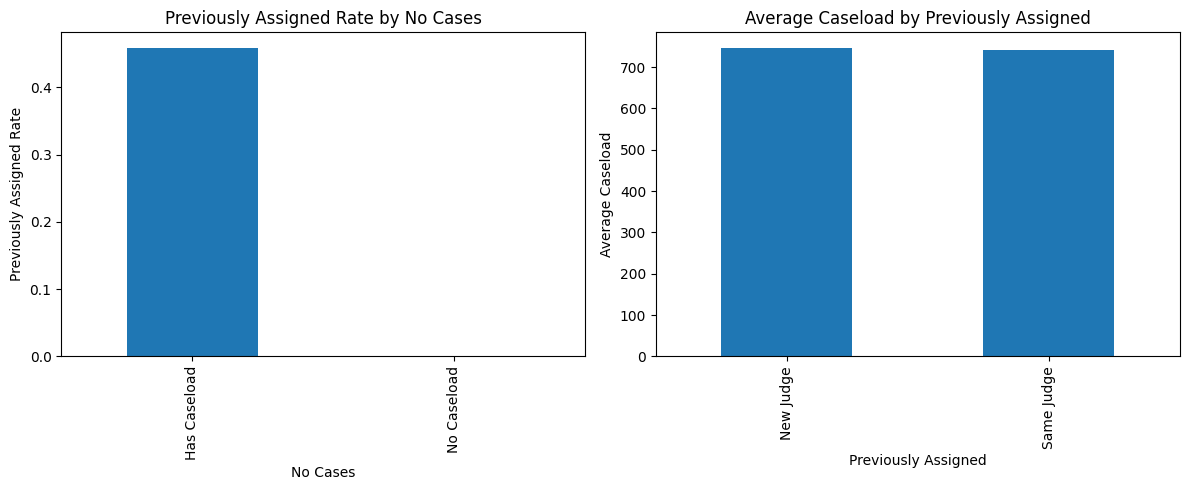

In [170]:
# Add the no_cases feature
df_with_features = add_no_cases_feature(df_with_features)

# Add the previously_assigned feature
df_with_features = add_previously_assigned_feature(df_with_features, hsg_hearings_df)

# Check the results
print("\nFeature statistics:")
print(f"No cases (binary): {df_with_features['no_cases'].sum()} records ({df_with_features['no_cases'].mean()*100:.2f}%)")
print(f"Previously assigned (binary): {df_with_features['previously_assigned'].sum()} records ({df_with_features['previously_assigned'].mean()*100:.2f}%)")

# Visualize the relationship between these features
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df_with_features.groupby('no_cases')['previously_assigned'].mean().plot(kind='bar')
plt.title('Previously Assigned Rate by No Cases')
plt.xlabel('No Cases')
plt.ylabel('Previously Assigned Rate')
plt.xticks([0, 1], ['Has Caseload', 'No Caseload'])

plt.subplot(1, 2, 2)
df_with_features.groupby('previously_assigned')['caseload'].mean().plot(kind='bar')
plt.title('Average Caseload by Previously Assigned')
plt.xlabel('Previously Assigned')
plt.ylabel('Average Caseload')
plt.xticks([0, 1], ['New Judge', 'Same Judge'])

plt.tight_layout()
plt.show()

Merging osc_date from asylum dataset...
  osc_date already exists in the dataframe
Calculating 'length_of_proceedings' feature...
Length of proceedings calculation complete:
  Total records processed: 2161
  Records with valid calculations: 2161 (100.00%)
  Records with missing data: 0
  Records with negative values: 0 (0.00% of valid)
  Mean length of proceedings (days): 870.57
  Median length of proceedings (days): 551.00
  Min length of proceedings (days): 0
  Max length of proceedings (days): 9137


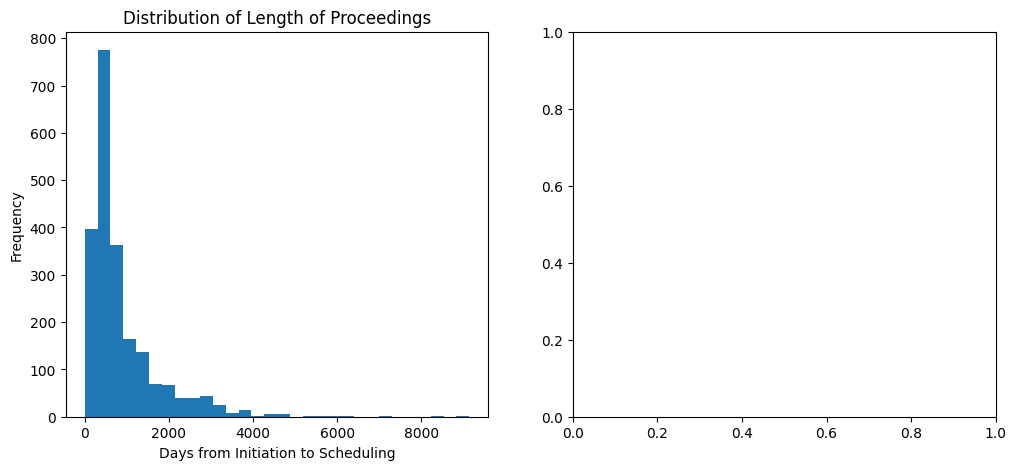

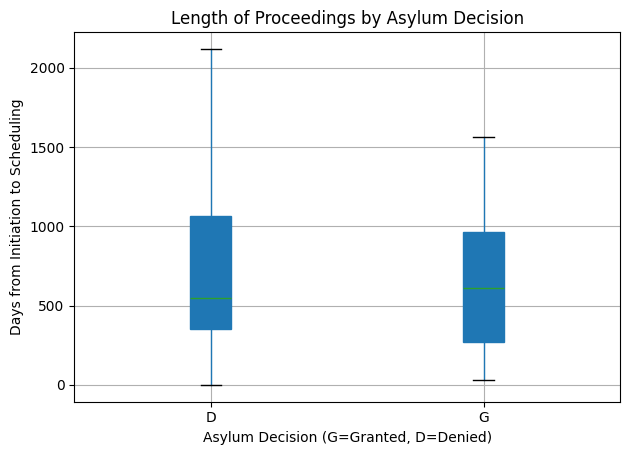

In [173]:
def merge_osc_date(df_with_features, asy_filt_df):
    """
    Merge the osc_date feature from the filtered asylum dataset
    
    Parameters:
    - df_with_features: DataFrame with our features calculated so far
    - asy_filt_df: Original filtered asylum dataset with osc_date
    
    Returns:
    - Updated DataFrame with osc_date merged in
    """
    print("Merging osc_date from asylum dataset...")
    
    # Check if osc_date is already in the dataframe
    if 'osc_date' in df_with_features.columns:
        print(f"  osc_date already exists in the dataframe")
        return df_with_features
        
    # Create a copy of the dataframe to modify
    result_df = df_with_features.copy()
    
    # Create a subset of the asylum dataset with just idncase and osc_date
    osc_data = asy_filt_df[['idncase', 'osc_date']].copy()
    
    # Remove any duplicates to ensure a clean join
    osc_data = osc_data.drop_duplicates('idncase')
    
    # Count initial records
    initial_count = len(result_df)
    
    # Merge the osc_date into our feature dataframe
    result_df = result_df.merge(
        osc_data,
        on='idncase',
        how='left',
        suffixes=('', '_asylum')
    )
    
    # Count after merge
    final_count = len(result_df)
    missing_osc = result_df['osc_date'].isna().sum()
    
    # Print summary
    print(f"  Records before merge: {initial_count}")
    print(f"  Records after merge: {final_count}")
    print(f"  Records with missing osc_date: {missing_osc} ({missing_osc/final_count*100:.2f}%)")
    
    if initial_count != final_count:
        print(f"  WARNING: Record count changed during merge. Check for duplicate idncase values.")
    
    return result_df

# Apply the merge to get osc_date
df_with_features = merge_osc_date(df_with_features, filt_asy_df)

# Now we can proceed with calculating the length of proceedings
def add_length_of_proceedings_feature(df):
    """
    Calculate the length of proceedings (days elapsed from case initiation to scheduling)
    
    Parameters:
    - df: DataFrame with our asylum case scheduling records including osc_date
    
    Returns:
    - Updated DataFrame with 'length_of_proceedings' column added
    """
    print("Calculating 'length_of_proceedings' feature...")
    
    # Create a copy of the dataframe to modify
    result_df = df.copy()
    result_df['length_of_proceedings'] = None  # Initialize feature column
    
    # Count of issues for reporting
    missing_data = 0
    negative_values = 0
    
    # Process each record
    for idx, row in result_df.iterrows():
        # Get the dates with robust error handling
        try:
            # Get scheduling date
            if 'input_date' in row and pd.notna(row['input_date']):
                scheduling_date = pd.to_datetime(row['input_date'])
            else:
                print(f"Warning: Missing input_date for record {idx}")
                missing_data += 1
                continue
                
            # Get case initiation date (osc_date)
            if 'osc_date' in row and pd.notna(row['osc_date']):
                initiation_date = pd.to_datetime(row['osc_date'])
            else:
                print(f"Warning: Missing osc_date for record {idx}")
                missing_data += 1
                continue
                
            # Calculate days elapsed
            days_elapsed = (scheduling_date - initiation_date).days
            
            # Check for negative values (scheduling before initiation)
            if days_elapsed < 0:
                negative_values += 1
                # We'll still store negative values but flag them
                
            # Store the value
            result_df.at[idx, 'length_of_proceedings'] = days_elapsed
            
        except Exception as e:
            print(f"Error calculating length_of_proceedings for record {idx}: {e}")
            missing_data += 1
    
    # Print summary statistics
    valid_records = result_df['length_of_proceedings'].notna()
    print(f"Length of proceedings calculation complete:")
    print(f"  Total records processed: {len(result_df)}")
    print(f"  Records with valid calculations: {valid_records.sum()} ({valid_records.mean()*100:.2f}%)")
    print(f"  Records with missing data: {missing_data}")
    print(f"  Records with negative values: {negative_values} ({negative_values/valid_records.sum()*100:.2f}% of valid)")
    
    if valid_records.sum() > 0:
        print(f"  Mean length of proceedings (days): {result_df.loc[valid_records, 'length_of_proceedings'].mean():.2f}")
        print(f"  Median length of proceedings (days): {result_df.loc[valid_records, 'length_of_proceedings'].median():.2f}")
        print(f"  Min length of proceedings (days): {result_df.loc[valid_records, 'length_of_proceedings'].min()}")
        print(f"  Max length of proceedings (days): {result_df.loc[valid_records, 'length_of_proceedings'].max()}")
    
    return result_df

# Apply the length of proceedings calculation
df_with_features = add_length_of_proceedings_feature(df_with_features)

# Visualize the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_with_features['length_of_proceedings'].dropna(), bins=30)
plt.title('Distribution of Length of Proceedings')
plt.xlabel('Days from Initiation to Scheduling')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
# Create a boxplot grouped by decision
boxplot = df_with_features.boxplot(column='length_of_proceedings', by='appl_dec', 
                                   showfliers=False, patch_artist=True)
plt.title('Length of Proceedings by Asylum Decision')
plt.suptitle('')  # Remove the automatic suptitle
plt.xlabel('Asylum Decision (G=Granted, D=Denied)')
plt.ylabel('Days from Initiation to Scheduling')

plt.tight_layout()
plt.show()

In [174]:
df_with_features

,idnschedule,idnproceeding,idncase,osc_date,generation,sub_generation,rec_type,lang,hearing_loc_code,base_city_code,...,blnclockoverride,eoirattorneyid,appl_dec,comp_date,is_reassigned,caseload,time_to_next,no_cases,previously_assigned,length_of_proceedings
0,40233906,4795705,6188414,2009-03-10,98,NaN,X,ENG,HSG,HSG,...,None,0FBC7493-3683-E211-AC6D-F4CE46838609,D,2022-02-22,True,137,0.003472,0,1,4676
1,40329948,4821463,3006125,1999-02-04,97,NaN,X,SP,HSG,HSG,...,None,C6F8E064-1FE2-E411-A083-F4CE46822D51,D,2022-02-22,True,144,0.020139,0,0,8376
2,40334194,4880640,6264724,2009-06-22,99,NaN,X,SP,HSG,HSG,...,None,A6BE9B7D-6CF0-46AB-81AD-308D90F74DDE,D,2022-02-28,True,156,0.002083,0,1,4585
3,40354901,4884001,6215700,2009-04-14,98,NaN,X,SP,HSG,HSG,...,None,E7659A18-6367-E311-84E6-F4CE46838609,D,2022-02-28,True,156,0.002083,0,0,4656
4,40333845,4921623,6268506,2009-06-18,98,NaN,X,SP,HSG,HSG,...,None,40BA7493-3683-E211-AC6D-F4CE46838609,D,2022-02-18,True,154,0.004861,0,1,4589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2156,50920221,14641116,9885110,2021-02-24,98,NaN,X,SP,HSG,HSG,...,None,C441DB8C-8CC7-4273-8479-9648307A0CB8,D,2024-08-21,True,383,2.002083,0,0,1237
2157,50920222,14641118,9885134,2021-02-24,98,NaN,X,SP,HSG,HSG,...,None,C441DB8C-8CC7-4273-8479-9648307A0CB8,D,2024-08-21,True,383,2.002083,0,0,1237
2158,50920223,14641122,9885149,2021-02-24,98,NaN,X,SP,HSG,HSG,...,None,C441DB8C-8CC7-4273-8479-9648307A0CB8,D,2024-08-21,True,383,2.002083,0,0,1237
2159,50647687,14676830,13842624,2024-03-28,98,NaN,X,SP,HSG,HSG,...,None,250546F2-E0D1-4D7B-B7E9-DCF33392670D,D,2025-01-17,False,1231,0.053472,0,0,85


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_900620/1199148525.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  caseload_grant_rate = regression_df.groupby('caseload_quartile')['asylum_granted'].mean()
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type befo

Preparing regression dataset...
Regression dataset prepared:
  Original asylum records: 2161
  Original feature records: 2161
  Final merged records: 2167

Missing values in key fields:

Asylum granted rate: 7.34%

Number of unique judges: 15
Top 10 judges by number of cases:
ij_code
CMS    346
AAJ    272
DAJ    257
GYH    239
KBR    235
CDK    132
JJC    123
JNM    117
KYT    106
CMR    100
Name: count, dtype: int64

Asylum grant rates by judge (minimum 30 cases):
             mean  count
ij_code                 
GYH      0.234310    239
CDK      0.227273    132
AWS      0.113636     44
CMR      0.110000    100
CMS      0.057803    346
MGC      0.055556     54
AAJ      0.044118    272
DMP      0.031915     94
KYT      0.028302    106
DAJ      0.027237    257


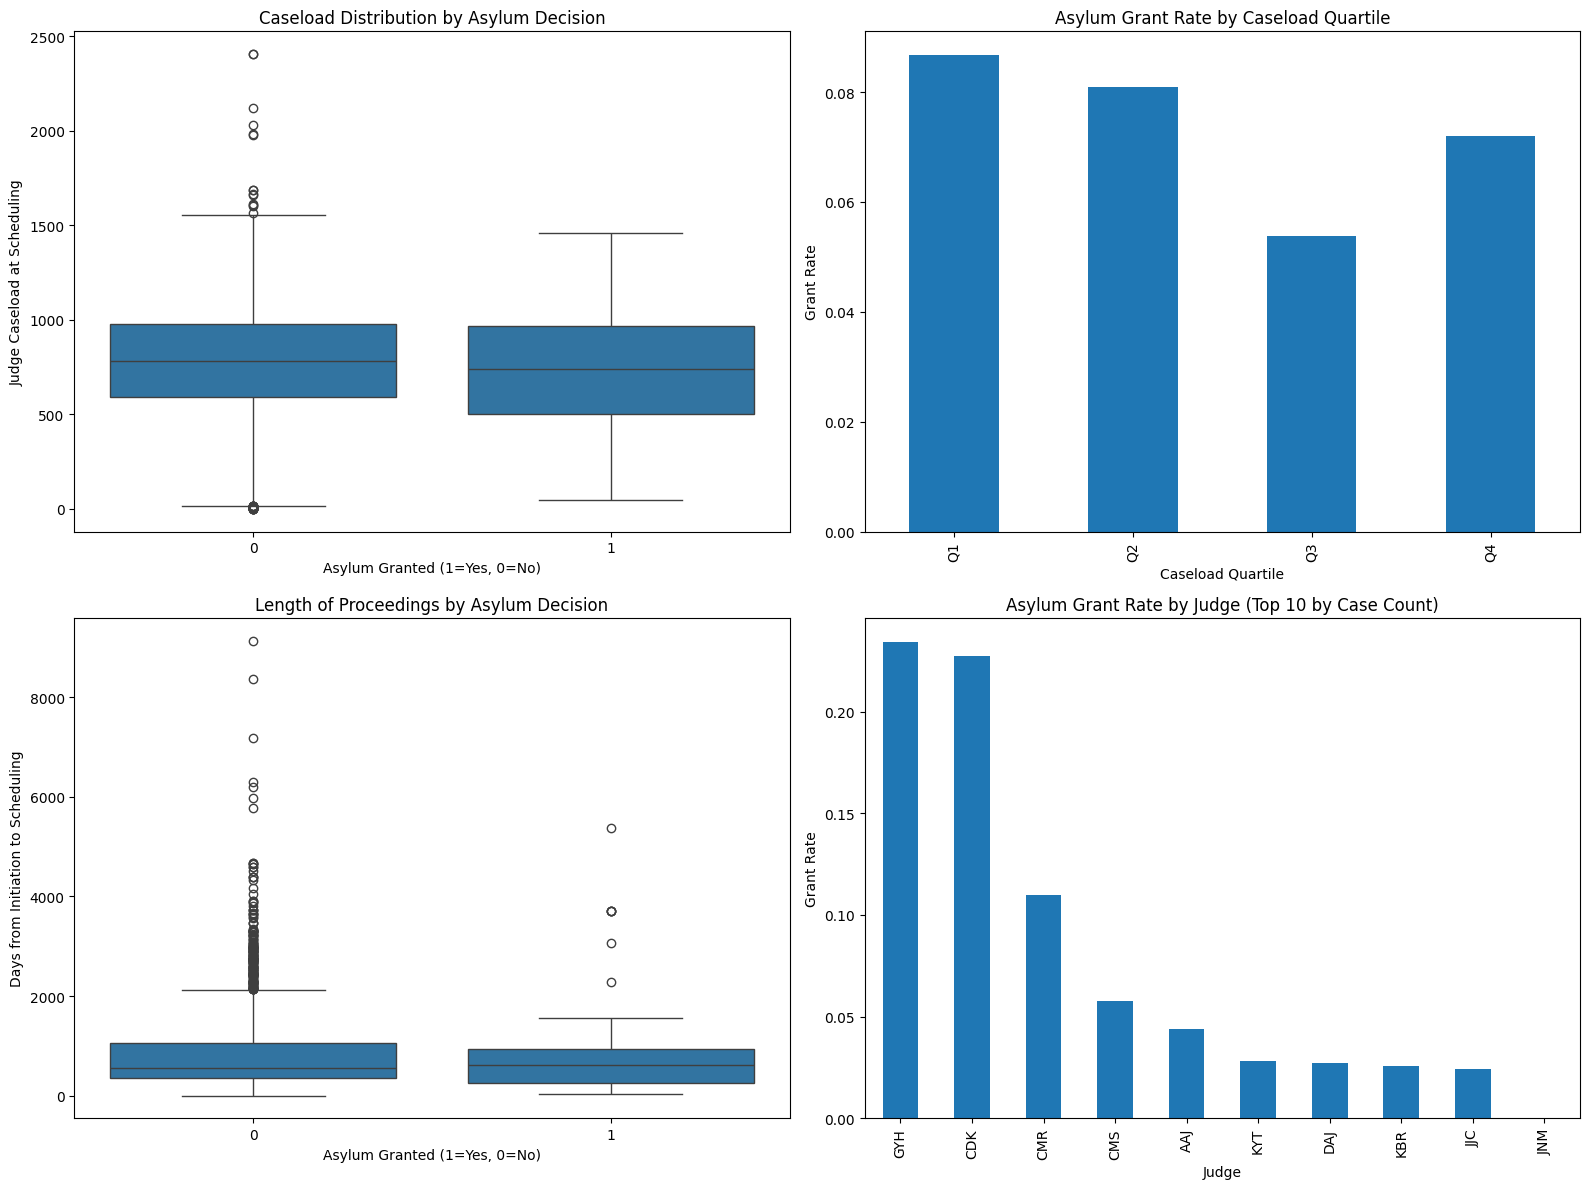


Regression dataset saved to 'asylum_regression_dataset.csv'

Descriptive statistics for numerical features:
          caseload  asylum_granted
count  2167.000000     2167.000000
mean    744.592063        0.073373
std     330.955130        0.260808
min       0.000000        0.000000
25%     579.500000        0.000000
50%     782.000000        0.000000
75%     978.500000        0.000000
max    2406.000000        1.000000


In [178]:
def prepare_regression_dataset(filt_asy_df, df_with_features):
    """
    Prepare the final dataset for regression analysis by merging
    essential fields from both dataframes
    
    Parameters:
    - filt_asy_df: Filtered asylum dataframe
    - df_with_features: Dataframe with calculated features
    
    Returns:
    - Merged dataframe with only the required fields for regression
    """
    print("Preparing regression dataset...")
    
    # Select required fields from filt_asy_df
    asylum_fields = filt_asy_df[['idncase', 'idnproceeding', 'appl_dec', 
                                'ij_code', 'hearing_date', 'hearing_time']].copy()
    
    # Select required fields from df_with_features
    feature_fields = df_with_features[['idnschedule', 'idncase', 'caseload', 
                                      'time_to_next', 'no_cases', 
                                      'previously_assigned', 'length_of_proceedings']].copy()
    
    # Merge the dataframes on idncase
    regression_df = asylum_fields.merge(
        feature_fields,
        on='idncase',
        how='inner',
        suffixes=('', '_schedule')
    )
    
    # Print summary statistics
    print(f"Regression dataset prepared:")
    print(f"  Original asylum records: {len(filt_asy_df)}")
    print(f"  Original feature records: {len(df_with_features)}")
    print(f"  Final merged records: {len(regression_df)}")
    
    # Check for missing values in key fields
    print("\nMissing values in key fields:")
    for col in regression_df.columns:
        missing = regression_df[col].isna().sum()
        if missing > 0:
            print(f"  {col}: {missing} ({missing/len(regression_df)*100:.2f}%)")
    
    # Convert appl_dec to binary outcome (1 = Granted, 0 = Denied)
    regression_df['asylum_granted'] = (regression_df['appl_dec'] == 'G').astype(int)
    print(f"\nAsylum granted rate: {regression_df['asylum_granted'].mean()*100:.2f}%")
    
    # Check for judge distribution
    judge_counts = regression_df['ij_code'].value_counts()
    print(f"\nNumber of unique judges: {len(judge_counts)}")
    print(f"Top 10 judges by number of cases:")
    print(judge_counts.head(10))
    
    # Calculate asylum grant rate by judge for judges with at least 30 cases
    grant_by_judge = regression_df.groupby('ij_code')['asylum_granted'].agg(['mean', 'count'])
    grant_by_judge = grant_by_judge[grant_by_judge['count'] >= 30].sort_values('mean', ascending=False)
    
    print(f"\nAsylum grant rates by judge (minimum 30 cases):")
    print(grant_by_judge.head(10))
    
    return regression_df

# Prepare the regression dataset
regression_df = prepare_regression_dataset(filt_asy_df, df_with_features)

# Visualize key relationships
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with multiple plots
plt.figure(figsize=(16, 12))

# Plot 1: Caseload distribution by asylum decision
plt.subplot(2, 2, 1)
sns.boxplot(x='asylum_granted', y='caseload', data=regression_df)
plt.title('Caseload Distribution by Asylum Decision')
plt.xlabel('Asylum Granted (1=Yes, 0=No)')
plt.ylabel('Judge Caseload at Scheduling')

# Plot 2: Grant rate by caseload quartiles
plt.subplot(2, 2, 2)
regression_df['caseload_quartile'] = pd.qcut(regression_df['caseload'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
caseload_grant_rate = regression_df.groupby('caseload_quartile')['asylum_granted'].mean()
caseload_grant_rate.plot(kind='bar')
plt.title('Asylum Grant Rate by Caseload Quartile')
plt.xlabel('Caseload Quartile')
plt.ylabel('Grant Rate')

# Plot 3: Length of proceedings distribution by decision
plt.subplot(2, 2, 3)
sns.boxplot(x='asylum_granted', y='length_of_proceedings', data=regression_df)
plt.title('Length of Proceedings by Asylum Decision')
plt.xlabel('Asylum Granted (1=Yes, 0=No)')
plt.ylabel('Days from Initiation to Scheduling')

# Plot 4: Grant rate by judge (top 10 by case count)
plt.subplot(2, 2, 4)
top_judges = regression_df['ij_code'].value_counts().head(10).index
top_judge_data = regression_df[regression_df['ij_code'].isin(top_judges)]
grant_rate_by_judge = top_judge_data.groupby('ij_code')['asylum_granted'].mean().sort_values(ascending=False)
grant_rate_by_judge.plot(kind='bar')
plt.title('Asylum Grant Rate by Judge (Top 10 by Case Count)')
plt.xlabel('Judge')
plt.ylabel('Grant Rate')

plt.tight_layout()
plt.savefig('regression_dataset_analysis.png')
plt.show()
hearing_datetime
# Save the prepared dataset
regression_df.to_csv('asylum_regression_dataset.csv', index=False)
print("\nRegression dataset saved to 'asylum_regression_dataset.csv'")

# Provide descriptive statistics for numerical features
print("\nDescriptive statistics for numerical features:")
print(regression_df[['caseload', 'time_to_next', 'length_of_proceedings', 'asylum_granted']].describe())

In [179]:
regression_df

,idncase,idnproceeding,appl_dec,ij_code,hearing_date,hearing_time,idnschedule,caseload,time_to_next,no_cases,previously_assigned,length_of_proceedings,asylum_granted,caseload_quartile
0,6188414,4795705,D,NES,2009-05-11,08:00:00,40233906,137,0.003472,0,1,4676,0,Q1
1,3006125,4821463,D,NES,2009-06-03,08:30:00,40329948,144,0.020139,0,0,8376,0,Q1
2,6264724,4880640,D,NES,2009-07-23,08:30:00,40334194,156,0.002083,0,1,4585,0,Q1
3,6215700,4884001,D,NES,2009-07-22,09:00:00,40354901,156,0.002083,0,0,4656,0,Q1
4,6268506,4921623,D,NES,2009-09-23,08:30:00,40333845,154,0.004861,0,1,4589,0,Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2162,9885110,14641116,D,CMR,2025-06-17,13:00:00,50920221,383,2.002083,0,0,1237,0,Q1
2163,9885134,14641118,D,CMR,2025-06-17,13:00:00,50920222,383,2.002083,0,0,1237,0,Q1
2164,9885149,14641122,D,CMR,2025-06-17,13:00:00,50920223,383,2.002083,0,0,1237,0,Q1
2165,13842624,14676830,D,DAJ,2024-08-13,13:00:00,50647687,1231,0.053472,0,0,85,0,Q4


In [ ]:
# from pyfixest import estimation
# model = estimation.estimation.feols('grant ~ 1 | ij_code', #Need to add year_month FEs
#               data=recent_cases,
#               vcov={'CRV1': 'ij_code'})
# judge_effects_no_schedule = pd.Series(model.fixef()['C(ij_code)'])

# # Repeat this but get the judge effects with the scheduling data added in

In [181]:
import pandas as pd
import numpy as np
from pyfixest import estimation
import matplotlib.pyplot as plt
import seaborn as sns

# Load the regression dataset if needed
# regression_df = pd.read_csv('asylum_regression_dataset.csv')

# 1. Prepare date variables for fixed effects
def prepare_regression_data(regression_df):
    """
    Prepare the regression dataset by adding time period fixed effect variables
    """
    # Create a copy to avoid modifying the original
    reg_data = regression_df.copy()
    
    # Convert hearing_date to datetime if not already
    if not pd.api.types.is_datetime64_dtype(reg_data['hearing_date']):
        reg_data['hearing_date'] = pd.to_datetime(reg_data['hearing_date'])
    
    # Create time fixed effect variables
    reg_data['year'] = reg_data['hearing_date'].dt.year
    reg_data['quarter'] = reg_data['hearing_date'].dt.quarter
    reg_data['year_quarter'] = reg_data['hearing_date'].dt.year.astype(str) + 'Q' + reg_data['hearing_date'].dt.quarter.astype(str)
    reg_data['month'] = reg_data['hearing_date'].dt.month
    reg_data['year_month'] = reg_data['hearing_date'].dt.year.astype(str) + '-' + reg_data['hearing_date'].dt.month.astype(str).str.zfill(2)
    
    # Ensure variables are properly formatted for regression
    reg_data['asylum_granted'] = reg_data['asylum_granted'].astype(float)
    reg_data['no_cases'] = reg_data['no_cases'].astype(float)
    reg_data['previously_assigned'] = reg_data['previously_assigned'].astype(float)
    
    # Fill missing values for numerical features with median
    for col in ['caseload', 'time_to_next', 'length_of_proceedings']:
        if reg_data[col].isna().sum() > 0:
            median_val = reg_data[col].median()
            reg_data[col] = reg_data[col].fillna(median_val)
            print(f"Filled {reg_data[col].isna().sum()} missing values in {col} with median ({median_val})")
    
    return reg_data

# Prepare the data
reg_data = prepare_regression_data(regression_df)
reg_data

,idncase,idnproceeding,appl_dec,ij_code,hearing_date,hearing_time,idnschedule,caseload,time_to_next,no_cases,previously_assigned,length_of_proceedings,asylum_granted,caseload_quartile,year,quarter,year_quarter,month,year_month
0,6188414,4795705,D,NES,2009-05-11,08:00:00,40233906,137,0.003472,0.0,1.0,4676,0.0,Q1,2009,2,2009Q2,5,2009-05
1,3006125,4821463,D,NES,2009-06-03,08:30:00,40329948,144,0.020139,0.0,0.0,8376,0.0,Q1,2009,2,2009Q2,6,2009-06
2,6264724,4880640,D,NES,2009-07-23,08:30:00,40334194,156,0.002083,0.0,1.0,4585,0.0,Q1,2009,3,2009Q3,7,2009-07
3,6215700,4884001,D,NES,2009-07-22,09:00:00,40354901,156,0.002083,0.0,0.0,4656,0.0,Q1,2009,3,2009Q3,7,2009-07
4,6268506,4921623,D,NES,2009-09-23,08:30:00,40333845,154,0.004861,0.0,1.0,4589,0.0,Q1,2009,3,2009Q3,9,2009-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2162,9885110,14641116,D,CMR,2025-06-17,13:00:00,50920221,383,2.002083,0.0,0.0,1237,0.0,Q1,2025,2,2025Q2,6,2025-06
2163,9885134,14641118,D,CMR,2025-06-17,13:00:00,50920222,383,2.002083,0.0,0.0,1237,0.0,Q1,2025,2,2025Q2,6,2025-06
2164,9885149,14641122,D,CMR,2025-06-17,13:00:00,50920223,383,2.002083,0.0,0.0,1237,0.0,Q1,2025,2,2025Q2,6,2025-06
2165,13842624,14676830,D,DAJ,2024-08-13,13:00:00,50647687,1231,0.053472,0.0,0.0,85,0.0,Q4,2024,3,2024Q3,8,2024-08


In [186]:
from pyfixest import estimation
model = estimation.estimation.feols('asylum_granted ~ 1 | ij_code + year_month',
              data=reg_data,
              vcov={'CRV1': 'ij_code'})
judge_effects_no_schedule = pd.Series(model.fixef()['C(ij_code)'])
judge_effects_no_schedule
# Repeat this but get the judge effects with the scheduling data added in

AAJ   -0.010774
AWS    0.041036
CDK    0.133377
CMR    0.066151
CMS   -0.007628
DAJ   -0.021584
DMP   -0.031883
GYH    0.179479
JGC   -0.039460
JJC   -0.012105
JNM   -0.080196
KBR   -0.032604
KYT   -0.021570
MGC   -0.003174
NES    0.000007
dtype: float64

In [187]:
model = estimation.estimation.feols('asylum_granted ~ time_to_next + caseload + no_cases + previously_assigned + length_of_proceedings | ij_code + year_month',
              data=reg_data,
              vcov={'CRV1': 'ij_code'})
judge_effects_schedule = pd.Series(model.fixef()['C(ij_code)'])
judge_effects_schedule
# Repeat this but get the judge effects with the scheduling data added in

/home/shuba/.local/lib/python3.10/site-packages/pyfixest/estimation/feols_.py:2545: UserWarning: 
            The following variables are collinear: ['time_to_next[T.0.12222222222222222]', 'time_to_next[T.0.21597222222222223]', 'time_to_next[T.0.7958333333333333]', 'time_to_next[T.1.0090277777777779]', 'time_to_next[T.1.2534722222222223]', 'time_to_next[T.2.002083333333333]', 'no_cases', 'length_of_proceedings[T.6]', 'length_of_proceedings[T.21]', 'length_of_proceedings[T.32]', 'length_of_proceedings[T.42]', 'length_of_proceedings[T.44]', 'length_of_proceedings[T.47]', 'length_of_proceedings[T.72]', 'length_of_proceedings[T.82]', 'length_of_proceedings[T.88]', 'length_of_proceedings[T.90]', 'length_of_proceedings[T.97]', 'length_of_proceedings[T.99]', 'length_of_proceedings[T.101]', 'length_of_proceedings[T.106]', 'length_of_proceedings[T.107]', 'length_of_proceedings[T.111]', 'length_of_proceedings[T.113]', 'length_of_proceedings[T.125]', 'length_of_proceedings[T.127]', 'length_of_pro

AAJ    0.093069
AWS    0.243523
CDK    0.228910
CMR    0.024828
CMS    0.135554
DAJ    0.189824
DMP    0.253316
GYH    0.505857
JGC   -0.115201
JJC    0.111638
JNM    0.082029
KBR    0.164939
KYT    0.165703
MGC    0.321206
NES    0.102882
dtype: float64